# Solution Planning

## Input

1. Problema de negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização


2. Questões que serão respondidas
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?


3. Fonte de dados
    - Vendas de um e-commerce online, o periodo de um ano.

## Output

1. A indicação das pessoas que farão parte do programe de Insiders
    - Lista: cliente_id | is_insider
                10234   |    yes
                10235   |    no
                
2. Relatório com as respostas das perguntass de negócio.

## Task

## Desk Research

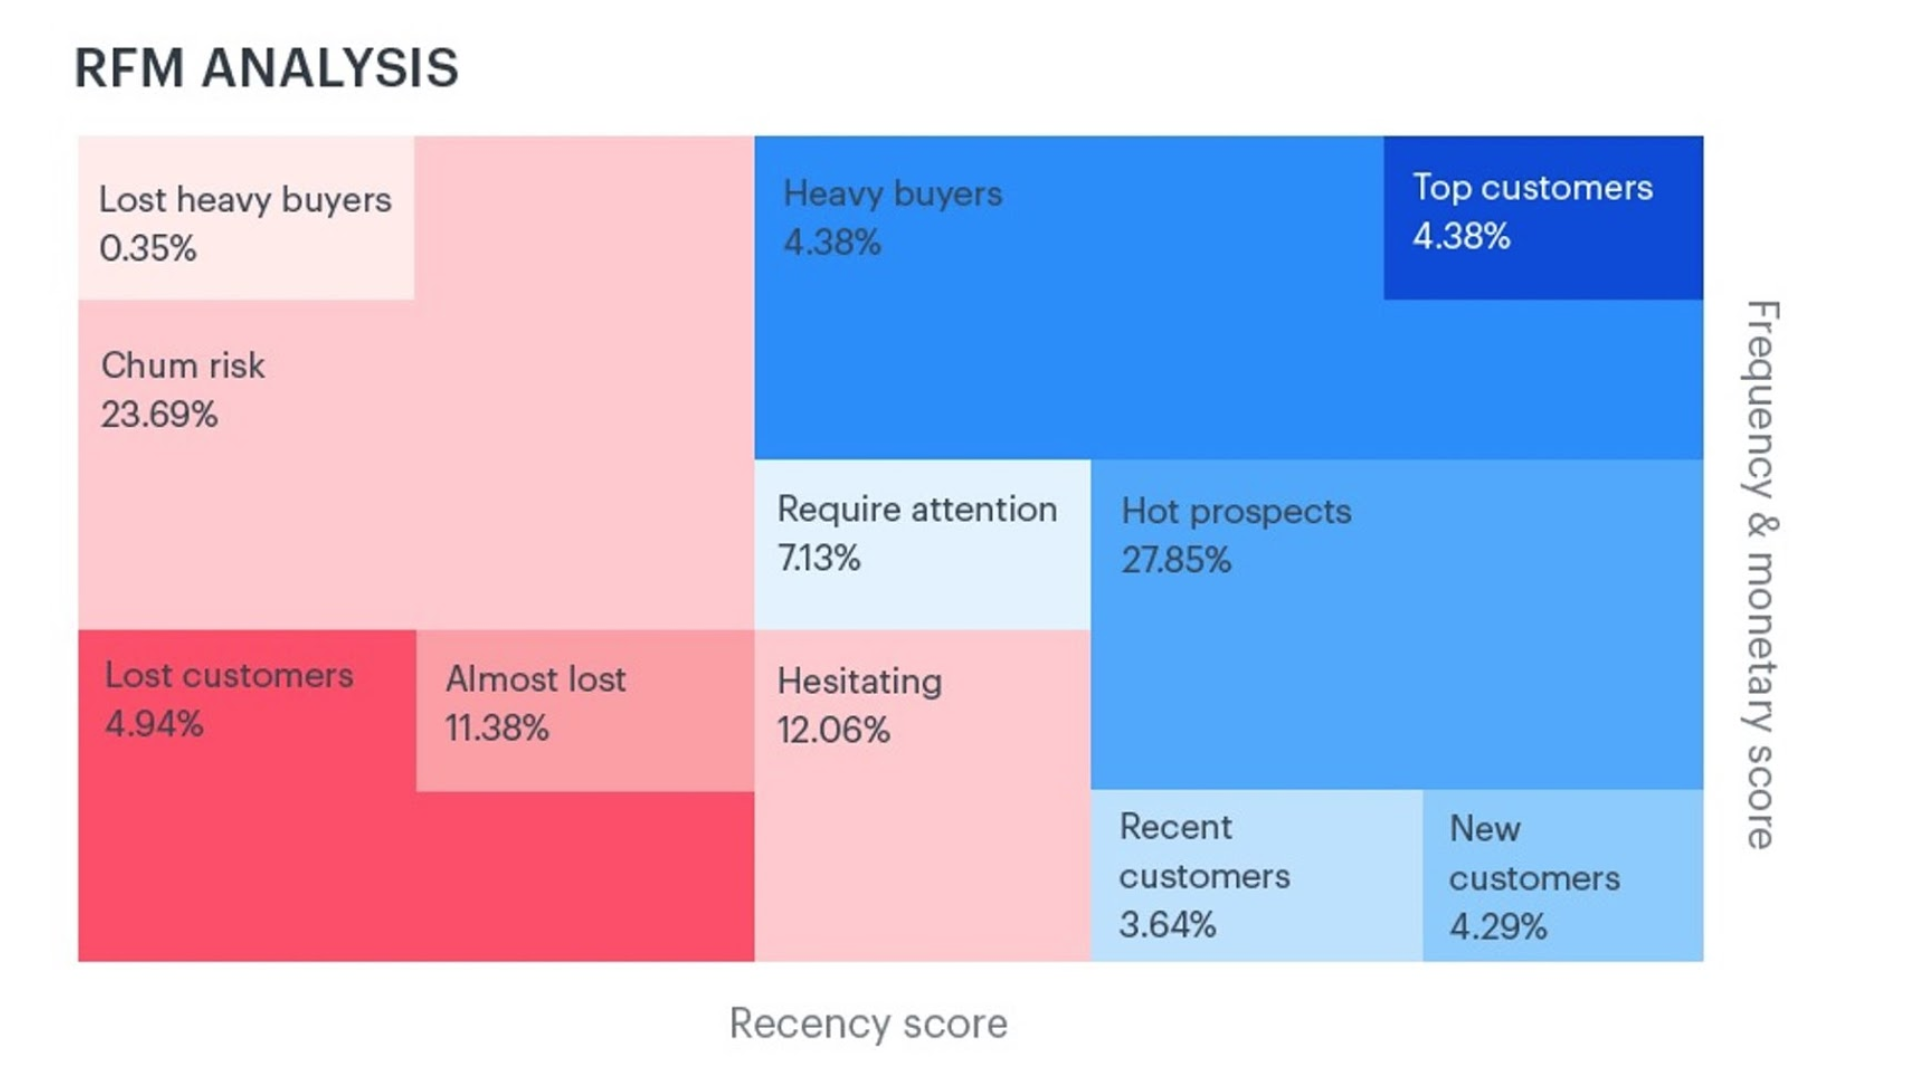

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

import umap.umap_ as umap

import re

from sklearn import preprocessing as pp

from pandas_profiling import ProfileReport

from sklearn.neighbors import NearestNeighbors

## Helper Functions

In [2]:
# Notebook configuration
display( HTML( '<style>.container { width:95% !important; }</style>') )

## Load Dataset

In [3]:
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='iso-8859-1')

# drop extra colum
df_raw = df_raw.drop(columns='Unnamed: 8')

# Data Cleaning & Data Description

In [4]:
# save pickle
pickle.dump(df_raw, open('../src/steps/df1.pkl', 'wb'))

# load pickle
df1 = pickle.load(open('../src/steps/df1.pkl', 'rb'))

## Rename Columns

In [5]:
# ordering columns
df1 = df1[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

# rename columns
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

## Data Dimensions

In [6]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 541909
Number of Cols: 8


## Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [9]:
print(f"Percentage of NAs: {len(df1[(df1['description'].isna()) | (df1['customer_id'].isna())]) / len(df1) * 100:.2f}")

Percentage of NAs: 24.93


### Replace NA

With the objective of retrieving data to enrich the analysis and identification of patterns of customer purchase behavior by the model, a unique customer_id was inserted in the records that had NA. When we are going to pass the list of customers from the groups, we will remove the customers that had the customet_id NA because they are impossible to identify. Measure taken solely and exclusively with the aim of identifying the pattern of customer purchase behavior.

Outro problema é que como nós vamos atribuir um novo customer_id para cada invoie_no, não vamos saber quando um mesmo customer comprou varias vezes.

In [10]:
# divide df into missing and not missing customer_id values
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
# Max value of customer_id in the dataset
print(f"Max value of customer_id in the dataset: {df_not_missing['customer_id'].max()}")

Max value of customer_id in the dataset: 18287.0


In [12]:
# get just unique invoice_no from df_missing
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())

# input a value from 19000 for each purchase
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge df_backup with original dataset (will result in x columns with the df1 values and a y column with the df_backup values) )
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce - combine the customer_id added for each purchase for all items from those purchases into the original dataset
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns (x and y)
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## Change dtypes

In [14]:
# [invoice_date] - change from object to datetime format
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# [customer_id] - verify if there are float values in the column, if not, change the format to int64
if [print(i) for i in df1['customer_id'] if i.is_integer() == False] == []:
    df1['customer_id'] = df1['customer_id'].astype('int64')

## Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [16]:
# central tendency metrics
mean_     = pd.DataFrame(num_attributes.mean()).T
median_   = pd.DataFrame(num_attributes.median()).T

# dispersion metrics
min_      = pd.DataFrame(num_attributes.min()).T
max_      = pd.DataFrame(num_attributes.max()).T
range_    = pd.DataFrame(num_attributes.max() - num_attributes.min()).T
std_      = pd.DataFrame(num_attributes.std()).T
skew_     = pd.DataFrame(num_attributes.skew()).T
kurtosis_ = pd.DataFrame(num_attributes.kurtosis()).T


metrics = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis',  ]
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.081158,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759853,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.411352,0.487449,-0.804287


#### <font color='red'> Numerical Attributes - Investigating </font>

1. Negative quantity ( can be return )
2. Preço unitario igual a 0 ( pode ser promoção )
3. Preço unitario negativo 

### Categorical Attributes

#### <font color='red'> Categorical Attributes - Investigating </font>

##### Invoice_no

In [17]:
# invoice_no with words
invoice_no_with_words = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x ))), :]

print(f'Exists {len(invoice_no_with_words["invoice_no"].unique())} unique invoice_no with words')
print(f'Exists {len(invoice_no_with_words)} invoice_no with words')
print(f'Exists {len(invoice_no_with_words[invoice_no_with_words["quantity"] < 0])} invoice_no with words and negative quantity')

Exists 3839 unique invoice_no with words
Exists 9291 invoice_no with words
Exists 9288 invoice_no with words and negative quantity


##### stock_code

In [18]:
# stock_code with letters
stock_code_with_letters = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

# stock_code only with letters
stock_code_only_with_letters = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]


print(f'Exists {len(stock_code_with_letters["stock_code"].unique())} unique stock_code with letters')
print(f'Exists {len(stock_code_with_letters["stock_code"])} stock_code with letters')
print(100 * '-')
print(f'Exists 6 types of stock_code only with letters: {stock_code_only_with_letters["stock_code"].unique()}')
print(f'Exists {len(stock_code_only_with_letters["stock_code"])} stock_code only with letters')

# action: remove stock_code in ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']

Exists 1124 unique stock_code with letters
Exists 54873 stock_code with letters
----------------------------------------------------------------------------------------------------
Exists 6 types of stock_code only with letters: ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']
Exists 2759 stock_code only with letters


##### description

In [19]:
# action: delete feature 

##### country

In [20]:
df1["country"].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [21]:
print(f'Exists {len(df1["country"].unique())} countries in the dataset')

Exists 38 countries in the dataset


In [22]:
# percentage of each country in the dataset
pd.DataFrame(df1['country'].value_counts(normalize=True)).head()

,country
United Kingdom,0.914320
Germany,0.017521
France,0.015790
EIRE,0.015124
Spain,0.004674


In [23]:
# quantity of customers by country in the dataset
df1[['country', 'customer_id']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# Data Filtering

In [24]:
# save pickle
pickle.dump(df1, open('../src/steps/df2.pkl', 'wb'))

# load pickle
df2 = pickle.load(open('../src/steps/df2.pkl', 'rb'))

In [25]:
# unit_price - remove unit price under 0.05 cents
df2 = df2[df2['unit_price'] > 0.04]

# stock_code - remove stock codes only with letters
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS',
 'B', 'CRUK'])]

# description - remove description column
df2 = df2.drop(columns='description')

# country - remove 'European Community' and 'Unspecified' values because they are unidentifiable (verify others approaches in future cycles)
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity - divide dataset into two datasets (returns and purchases)
df2_return = df2[df2['quantity'] < 0]
df2_purchase = df2[df2['quantity'] > 0]

# Feature Engineering

In [26]:
# save pickle
pickle.dump(df2, open('../src/steps/df3.pkl', 'wb'))

# load pickle
df3 = pickle.load(open('../src/steps/df3.pkl', 'rb'))

## Feature Creation

Feature Ideas
- Moving Average - 7d, 14d, 30d
- Quantidade de compras por mês, antes do dia 15 e depois do dia 15

In [27]:
# data reference (dataset with unique customers only (will be the pricipal df))
df_ref = pd.DataFrame(df3['customer_id']).drop_duplicates(ignore_index=True)

### Gross Revenue

In [28]:
# Gross Revenue of purchase: quantity * unit_price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# calculate de total revenue per customer
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# merge df_ref with df_monetary
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

C:\Users\victo\AppData\Local\Temp\ipykernel_10836\3839311384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### Recency Days

In [29]:
# # Recency: number of days since last purchase 
# obtain the last purchase date of each customer 
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# calculate the number of days since last purchase (use last purchase on dataset as 'today')
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days

# merge df_ref with recency days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### Quantity of Purchases

In [30]:
# Qnt_pur: total of purchases made by each customers

# obtain the quantity of purchase by customer
df_qnt_pur = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_qnt_pur = df_qnt_pur.rename(columns={'invoice_no': 'qnt_purchases'})

# merge df_ref with frequency
df_ref = pd.merge(df_ref, df_qnt_pur, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qnt_purchases    91
dtype: int64

### Quantity of Products Purchased 

In [31]:
# qnt_prod: total of products purchased by each customers

# obtain the quantity of products purchased by customer
df_qnt_prod = (df2_purchase.loc[:, ['customer_id', 'quantity']].groupby('customer_id')
                                                               .sum()
                                                               .reset_index()
                                                               .rename(columns={'quantity': 'qnt_products_purchased'}))

# merge df_ref with frequency
df_ref = pd.merge(df_ref, df_qnt_prod, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id                0
gross_revenue             91
recency_days              91
qnt_purchases             91
qnt_products_purchased    91
dtype: int64

### Quantity of Stock Code Purchased 

In [32]:
# qnt_stock_code: quantity of stock codes purchased by each customers

# obtain the quantity of stock codes purchased by customer
df_qnt_stock_code = (df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby('customer_id')
                                                                       .count()
                                                                       .reset_index()
                                                                       .rename(columns={'stock_code': 'qnt_stock_code'}))

# merge df_ref with df_qnt_stock_code
df_ref = pd.merge(df_ref, df_qnt_stock_code, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id                0
gross_revenue             91
recency_days              91
qnt_purchases             91
qnt_products_purchased    91
qnt_stock_code            91
dtype: int64

### Quantity of Products Types Purchased 

In [33]:
# qnt_prod_types: quantity of unique products purchased by each customers

# obtain the quantity of products types purchased by customer
df_qnt_prod_types = (df2_purchase.loc[:, ['customer_id', 'stock_code']].drop_duplicates()
                                                                       .groupby('customer_id')
                                                                       .count()
                                                                       .reset_index()
                                                                       .rename(columns={'stock_code': 'qnt_products_types_purchased'}))

# merge df_ref with df_qnt_prod_types
df_ref = pd.merge(df_ref, df_qnt_prod_types, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id                      0
gross_revenue                   91
recency_days                    91
qnt_purchases                   91
qnt_products_purchased          91
qnt_stock_code                  91
qnt_products_types_purchased    91
dtype: int64

### Avg TIcket

In [34]:
# Avg Ticket: mean of gross revenue for each customer
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})

# merge df_ref with avg ticket
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id                      0
gross_revenue                   91
recency_days                    91
qnt_purchases                   91
qnt_products_purchased          91
qnt_stock_code                  91
qnt_products_types_purchased    91
avg_ticket                      91
dtype: int64

### Avg Recency Days

*Testar eficácia, porem tem muitos contrapontos (utilizar para aprender a fazer o delocamento do tempo)

In [35]:
# Avg Recency Days: Average in days for all intervals between each customer's purchases

# Date each purchase customers made and sort the values to shift the data
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])

# shift previous data (customer_id, invoice_date) to the bottom line
df_aux['previous_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

# condition the calculation of the difference between the dates if the previous purchase is from the same customer
df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['previous_date'] - x['invoice_date']).days if x['customer_id'] == x['previous_customer_id'] else np.nan, axis=1)

# drop unnecessary columns
df_aux = df_aux.drop(columns=['invoice_date', 'previous_customer_id', 'previous_date']).dropna()

# group all purchases from the same customer and get the average recency in days
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge df_ref with df_avg_recency_days
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id                        0
gross_revenue                     91
recency_days                      91
qnt_purchases                     91
qnt_products_purchased            91
qnt_stock_code                    91
qnt_products_types_purchased      91
avg_ticket                        91
avg_recency_days                2816
dtype: int64

*Customers who had an id equal to NA and I assigned values >= 19000 cannot be considered in this calculation because it was not possible to identify how many different purchases each customer made since they did not have an id.

### Frequency Purchase

In [36]:
# obtain the highest and lowest purchase dates, calculate the difference between these dates (in days)
# and count the number of purchases made in that period.
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                      .groupby('customer_id')
                                                                      .agg(max_ = ('invoice_date', 'max'),
                                                                           min_ = ('invoice_date', 'min'),
                                                                           days_= ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                           buy_ = ('invoice_date', 'count'))
                                                                      .reset_index() )

# calculate the customer's purchase frequency (amount of purchases in the period divided by the number of days in the period)
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge df_ref with frequency
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

# verify na
df_ref.isna().sum()

customer_id                        0
gross_revenue                     91
recency_days                      91
qnt_purchases                     91
qnt_products_purchased            91
qnt_stock_code                    91
qnt_products_types_purchased      91
avg_ticket                        91
avg_recency_days                2816
frequency                         91
dtype: int64

*Note that the frequency is being calculated based on the number of days between the customer's first and last purchase, which can give the same value to customers who made 2 purchases in one day (2/1 = 2) or 10 purchases in 5 days (10/5 = 2), and this can lead to the same rate for very different frequency values in terms of significance. Another way to do this account is to compare the amount of purchases between the date of the customer's first purchase with the last purchase date of the dataset, for the account to be fairer.

### Quantity of Returns

In [37]:
# agroup de quantity of returns and get the abs value
df_returns = (df2_return[['customer_id', 'quantity']].groupby('customer_id')
                                                     .sum()
                                                     .apply(lambda x: abs(x))
                                                     .rename(columns={'quantity': 'qnt_returns'})
                                                     .reset_index())

# merge df_ref with df_returns
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')

# # verify na (found 4191 ustomers that never returned a purchase)
# df_ref.isna().sum()

# replace na: 0 
df_ref.loc[df_ref['qnt_returns'].isna(), 'qnt_returns'] = 0

# verify na
df_ref.isna().sum()

customer_id                        0
gross_revenue                     91
recency_days                      91
qnt_purchases                     91
qnt_products_purchased            91
qnt_stock_code                    91
qnt_products_types_purchased      91
avg_ticket                        91
avg_recency_days                2816
frequency                         91
qnt_returns                        0
dtype: int64

### Average Basket Size 

In [38]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                                             n_products=('quantity', 'sum'))
                                                                        .reset_index())

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']


# merge df_ref with df_returns
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left')


# verify na
df_ref.isna().sum()

customer_id                        0
gross_revenue                     91
recency_days                      91
qnt_purchases                     91
qnt_products_purchased            91
qnt_stock_code                    91
qnt_products_types_purchased      91
avg_ticket                        91
avg_recency_days                2816
frequency                         91
qnt_returns                        0
avg_basket_size                   91
dtype: int64

### Average Basket Variety

In [39]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('stock_code', 'nunique'))
                                                                          .reset_index())

df_aux['avg_basket_variety'] = df_aux['n_products'] / df_aux['n_purchase']


# merge df_ref with df_returns
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_variety']], on='customer_id', how='left')


# verify na
df_ref.isna().sum()

customer_id                        0
gross_revenue                     91
recency_days                      91
qnt_purchases                     91
qnt_products_purchased            91
qnt_stock_code                    91
qnt_products_types_purchased      91
avg_ticket                        91
avg_recency_days                2816
frequency                         91
qnt_returns                        0
avg_basket_size                   91
avg_basket_variety                91
dtype: int64

The NAs are because there are 91 clients in the original dataset (df_ref contains the unique ids) that do not have purchase records, only returns, so when we try to merge the NAs are generated.

## Features Description

- **gross_revenue:** Total billing per customer (without considering returns).

- **recency_days:** Number of days since last purchase (without considering returns).

- **qnt_purchases:** Quantity of purchases made by each customer (without considering returns).

- **qnt_products_purchased:** Sum of all products purchased by each customers (without considering returns).

- **qnt_stock_code:** Qauntity of stock code purchased in each basket by customers.

- **qnt_products_types_purchased:** Quantity of unique products purchased by each customers (without considering returns).

- **avg_ticket:** Average revenue from each customer (without considering returns).

- **avg_recency_days:** Average in days for all intervals between each customer's purchases (without considering returns).

- **frequency:** Rate that represents the amount of purchases in the period between the first and the last purchase divided by the number of days in this period (without considering returns).

- **qnt_returns:** Total amount of returned products.

- **avg_basket_size:** Average quantity of products in each purchase (without considering returns).

- **avg_basket_variety:** Average amount of unique products in each purchase (without considering returns).

# Exploratory Data Analysis

In [40]:
# save pickle
pickle.dump(df_ref, open('../src/steps/df4.pkl', 'wb'))

# load pickle
df4 = pickle.load(open('../src/steps/df4.pkl', 'rb'))

# drop nas generated in previous step
df4 = df4.dropna()

## Univariate Analysis

### Notas

1. Objetivo é achar variáveis que tenham variabilidade (verificar valores extremos em relação a média para ver se fazem sentido ou são erros)
    - Métricas:
        - Min, Max, Range
        - Média, Mediana
        - Desvio Padrão e Variância
        - Coeficiente de Variação (CV = desvio padrão / média)
        - Distribuição (concentração, variabilidade)
        

Classificar como **Baixa Variabilidade**, **Média Variabilidade** e **Alta Variabilidade**


1. **Gross Revenue:** 

2. **Recency Days:**

3. **Quantity of Purchases:** 

4. **Quantity of Products Purchased:** 

5. **Quantity of Stock Code:** 

6. **Quantity of Products Types Purchased:** 

7. **Average Ticket:** 

8. **Average Recency Days:** 

9. **Frequency:** 

10. **Quantity of Returns:**

11. **Average Basket Size:** 

12. **Average Basket Variety:** 

In [41]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')

## Bivariate Analysis

In [98]:
df4_aux = df4.drop(columns='customer_id')

In [99]:
fig = px.scatter_matrix(df4_aux)
fig.update_layout(width=2000, height=2000)
fig.update_traces(diagonal_visible=False)
fig.show()

## Study of Data Spaces

In [100]:
# instantiate Scaler
mm = pp.MinMaxScaler()

# apply initial scaler to data
df4_aux['gross_revenue']                = mm.fit_transform(df4_aux[['gross_revenue']])
df4_aux['recency_days']                 = mm.fit_transform(df4_aux[['recency_days']])         
df4_aux['qnt_purchases']                = mm.fit_transform(df4_aux[['qnt_purchases']])        
df4_aux['qnt_products_purchased']       = mm.fit_transform(df4_aux[['qnt_products_purchased']])         
df4_aux['qnt_stock_code']               = mm.fit_transform(df4_aux[['qnt_stock_code']])        
df4_aux['qnt_products_types_purchased'] = mm.fit_transform(df4_aux[['qnt_products_types_purchased']])
df4_aux['avg_ticket']                   = mm.fit_transform(df4_aux[['avg_ticket']])
df4_aux['avg_recency_days']             = mm.fit_transform(df4_aux[['avg_recency_days']])
df4_aux['frequency']                    = mm.fit_transform(df4_aux[['frequency']])
df4_aux['qnt_returns']                  = mm.fit_transform(df4_aux[['qnt_returns']])
df4_aux['avg_basket_size']              = mm.fit_transform(df4_aux[['avg_basket_size']])
df4_aux['avg_basket_variety']           = mm.fit_transform(df4_aux[['avg_basket_variety']])

# copy df to generate embedding
X = df4_aux.copy()

### PCA

In [101]:
from sklearn import decomposition as dd

In [102]:
%matplotlib inline
from matplotlib import pyplot as plt

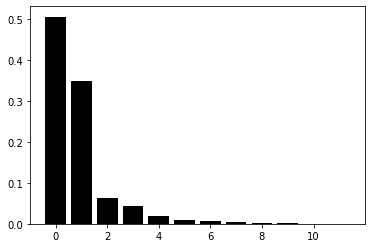

In [103]:
# instantiate PCA
pca = dd.PCA(n_components=X.shape[1])

# extract fitted and transformed data
principal_components = pca.fit_transform(X)

# plot features with more variability
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black');

# pca components
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

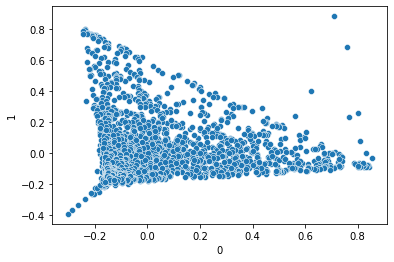

In [104]:
sns.scatterplot(x=0, y=1, data=df_pca)

### UMAP

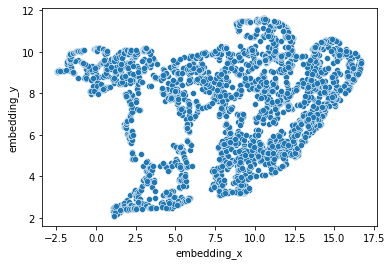

In [105]:
# instantiate UMAP
reducer = umap.UMAP(random_state=42)

# transform data space into embedding
embedding = reducer.fit_transform(X)

# define x and y and save on df_viz dataset
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

### t-SNE

In [106]:
from sklearn.manifold import TSNE

c:\users\victo\repos\insiders_clustering\insiders-venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\users\victo\repos\insiders_clustering\insiders-venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



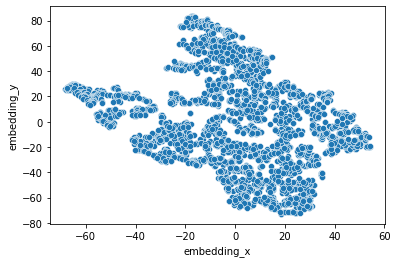

In [107]:
# instantiate t-SNE
reducer = TSNE(n_components=2, 
               random_state=42,
               n_jobs=-1)

# transform data space into embedding
embedding = reducer.fit_transform(X)

# define x and y and save on df_viz dataset
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

### Tree-Based Embedding

In [108]:
from sklearn import ensemble as en

In [109]:
# training dataset
X = df4.drop(columns=['customer_id', 'gross_revenue'])
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Get leafs and save in a dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2984,2726,3393,3328,3037,3308,3231,3140,3175,2986,...,3242,3229,3207,2799,3208,3111,2942,3367,3338,3293
1,2935,3112,3029,2958,3025,2978,2936,2808,3112,2947,...,2502,2548,2950,2762,3128,3010,2937,2925,2967,2835
2,3483,3616,3577,3405,3593,3618,3540,3546,3699,3615,...,3603,3471,3564,3555,3614,3563,3576,3613,3591,3666
3,2225,1967,1574,1434,1923,2217,2114,1790,2052,1745,...,1833,1435,2054,2062,1437,2279,1533,1448,2088,2278
4,218,270,299,599,175,701,724,692,174,165,...,423,219,681,583,689,741,200,901,697,207


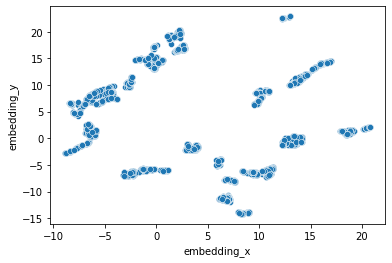

In [97]:
# instantiate UMAP
reducer = umap.UMAP(random_state=42)

# transform data space into embedding
embedding = reducer.fit_transform(df_leaf)

# define x and y and save on df_viz dataset
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca);

No espaço de embedding criado pela arvore com a variavel resposta sendo o gross_revenue, esses clientes são vizinhos (pertencem ao mesmo cluster).

# Data Preparation

In [110]:
# save pickle (embedding space)
pickle.dump(df4, open('../src/steps/df5.pkl', 'wb'))

# load pickle
df5 = pickle.load(open('../src/steps/df5.pkl', 'rb'))

# df to apply scalers and test
df5_aux = df5.copy()

In [56]:
# Scalers to test
mm = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler()

# features
mm_gr = pp.MinMaxScaler()
df5['gross_revenue']                = mm_gr.fit_transform(df5[['gross_revenue']])

mm_rd = pp.MinMaxScaler()
df5['recency_days']                 = mm_rd.fit_transform(df5[['recency_days']])

mm_qp = pp.MinMaxScaler()
df5['qnt_purchases']                = mm_qp.fit_transform(df5[['qnt_purchases']])

mm_qpp = pp.MinMaxScaler()
df5['qnt_products_purchased']       = mm_qpp.fit_transform(df5[['qnt_products_purchased']])

mm_qsc = pp.MinMaxScaler()
df5['qnt_stock_code']               = mm_qsc.fit_transform(df5[['qnt_stock_code']])

mm_qptp = pp.MinMaxScaler()
df5['qnt_products_types_purchased'] = mm_qptp.fit_transform(df5[['qnt_products_types_purchased']])

mm_at = pp.MinMaxScaler()
df5['avg_ticket']                   = mm_at.fit_transform(df5[['avg_ticket']])

mm_ard = pp.MinMaxScaler()
df5['avg_recency_days']             = mm_ard.fit_transform(df5[['avg_recency_days']])

mm_f = pp.MinMaxScaler()
df5['frequency']                    = mm_f.fit_transform(df5[['frequency']])

mm_qr = pp.MinMaxScaler()
df5['qnt_returns']                  = mm_qr.fit_transform(df5[['qnt_returns']])

mm_abs = pp.MinMaxScaler()
df5['avg_basket_size']              = mm_abs.fit_transform(df5[['avg_basket_size']])

mm_abv = pp.MinMaxScaler()
df5['avg_basket_variety']           = mm_abv.fit_transform(df5[['avg_basket_variety']])

# var to analize each feature easily
variable = 'avg_basket_variety'

Min: 0.2 - Max: 259.0


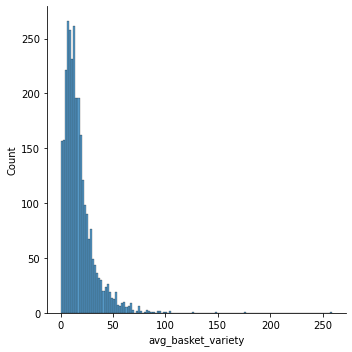

In [57]:
# Original distribution range
print(f"Min: {df5_aux[variable].min()} - Max: {df5_aux[variable].max()}")
sns.displot(df5_aux[variable]);

Min: 0.0 - Max: 1.0


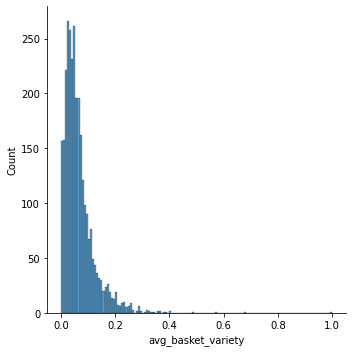

In [58]:
# Scaled distribution
print(f"Min: {df5[variable].min()} - Max: {df5[variable].max()}")
sns.displot(df5[variable]);

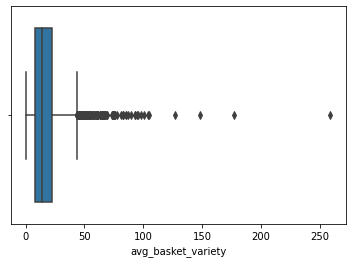

In [59]:
# BoxPlot to vsualize outliers
sns.boxplot(x=df5_aux[variable]);

# Feature Selection

In [60]:
# save pickle
pickle.dump(df5, open('../src/steps/df6.pkl', 'wb'))

# load pickle
df6 = pickle.load(open('../src/steps/df6.pkl', 'rb'))

A feature selection da clusterização é realizada olhando mais para o negócio do que para técnicas estatisticas e de ML.

Na análise do cluster vamos calcular a média das features para identificar os clientes, então todos as features que envolvem a criação de médias não faz sentido nós mantermos no nosso dataset.

Tambem vou retirar features muito similares, que conforma analisado na eda são 'qnt_purchases', 'qnt_products_purchased', 'qnt_stock_code' e deixar a 'qnt_products_types_purchased' somente pois representa bem as duas

In [61]:
'gross_revenue'                
'recency_days'                 
#'qnt_purchases'        
#'qnt_products_purchased'       
#'qnt_stock_code'              
'qnt_products_types_purchased' 
#'avg_ticket'                  
#'avg_recency_days'             
'frequency'                   
'qnt_returns'               
#'avg_basket_size'            
#'avg_basket_variety'     

'qnt_returns'

In [62]:
cols_select = ['customer_id', 'gross_revenue', 'recency_days','qnt_products_types_purchased', 'frequency', 'qnt_returns']

In [63]:
df6 = df6[cols_select]

# Machine Learning

In [64]:
# save pickle
pickle.dump(df6, open('../src/steps/df7.pkl', 'wb'))

# load pickle
df7 = pickle.load(open('../src/steps/df7.pkl', 'rb'))

## Hyperparameter Fine Tuning

In [65]:
# remove customer id column
x = df7.drop(columns=['customer_id'])

In [66]:
clusters = [2, 3, 4, 5, 6, 7]

### K-Means

In [67]:
# save SS values
kmeans_list = []

# loop for calculate all k values
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(init = 'random',
                            n_clusters = k,
                            n_init = 10,
                            max_iter = 300,
                            random_state = 42)
    
    # model training
    kmeans_model.fit(x)
    
    # get labels
    labels = kmeans_model.labels_ # or predict(x)
    
    # model performance SS
    sil = m.silhouette_score(x, labels, metric="euclidean")
    kmeans_list.append(sil)

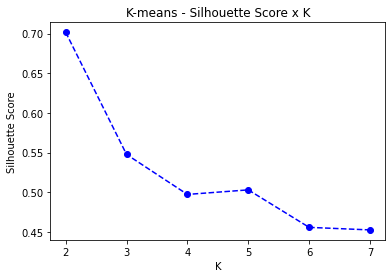

In [68]:
# visualize k values
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('K-means - Silhouette Score x K');

### GMM

In [69]:
from sklearn.mixture import GaussianMixture

In [70]:
# save SS values
gmm_list = []

# loop for calculate all k values
for k in clusters:
    # model definition
    gmm_model = GaussianMixture(n_components=k)
    
    # model training
    gmm_model.fit(x)
    
    # model predict
    labels = gmm_model.predict(x)
    
    # model performance
    sil = m.silhouette_score(x, labels, metric="euclidean")
    gmm_list.append(sil)

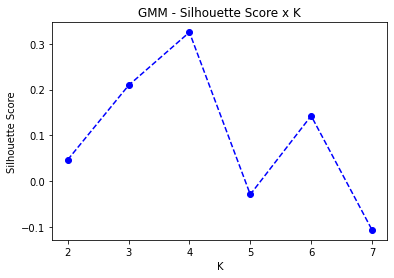

In [71]:
# visualize k values
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('GMM - Silhouette Score x K');

Para analisar o  GMM vamos utilizar mais 2 métricas:

    AIC - Ajuste dos dados
    BIC - Ajuste dos parametros

### Hierarchical Clustering

In [72]:
from scipy.cluster import hierarchy as hc

In [73]:
# model definition and training
hc_model = hc.linkage(x, 'ward')

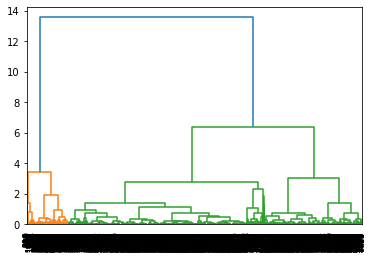

In [74]:
# Dendrogram
hc.dendrogram(hc_model, 
              leaf_rotation = 90,
              leaf_font_size = 8)



plt.plot();

NameError: name 'ax' is not defined

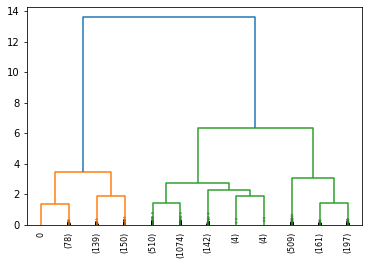

In [75]:
# Truncate Dendrogram
hc.dendrogram(hc_model, 
              truncate_mode='lastp',
              p=12,
              leaf_rotation = 90,
              leaf_font_size = 8,
              show_contracted = True)

plt.plot(ax=ax);

In [ ]:
# save SS values
hc_list = []

# loop for calculate all k values
for k in clusters:
    
    # model definition and training
    hc_model = hc.linkage(x, 'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # model performance
    sil = m.silhouette_score(x, labels, metric='euclidean')
    hc_list.append(sil)

In [ ]:
# visualize k values
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('H-Clustering - Silhouette Score x K');

### DBSCAN

In [ ]:
# define hyperparameters
eps = 0.2
min_samples = 20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training & predict (get labels)
labels = dbscan_model.fit_predict(x)

# model performance
sil = m.silhouette_score(x, labels, metric='euclidean')

print(f'Silhouette Score: {sil}')
print(f'Number of Clusters: {len(np.unique(labels))}')
print(np.unique(labels))

**Obtain the best k for DBSCAN with Nearest Neighbors:**

In [ ]:
# model definition & trainig
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(x)

# get distances between all data points
distances, indices = neighbors.kneighbors(x)

# sort min to max
distances = np.sort(distances, axis=0)

# get only a column to plot
distances = distances[:, 1]

In [ ]:
# plot quantity of points x average distance
plt.plot(distances);
plt.xlabel('Qnt. of data points');
plt.ylabel('Average distance between data points');

In [ ]:
# format dbscan ss to ut into dataframe
dbscan_list = [ 0.663609, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

### ML Results

In [ ]:
# DF to visualize best k of each model
df_results = pd.DataFrame(
    {'K-Means': kmeans_list,
     'GMM': gmm_list,
     'HC':  hc_list,
     'DBSCAN': dbscan_list}).T

# define clusters as columns    
df_results.columns = clusters

In [ ]:
# visualize high values of SS in a table
df_results.style.highlight_max(color='lightgreen', axis=1)

#### Silhouette Analysis

In [ ]:
# format plot
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(25, 20)

for k in clusters:
    q, mod = divmod(k, 2)
    
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(x) + (k+1)*10])
    
    # model definition & training
    hc_model = hc.linkage(x, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = m.silhouette_score(x, labels, metric='euclidean')
    print(f'For K = {k}. Silhouette Score: {ss}')

    samples_silhouette_values = m.silhouette_samples(x, labels)

    y_lower = 10
    for i in range(k):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # colors
        cmap = plt.get_cmap('Spectral')
        color = cmap(i / k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## Model Training

### K-Means

In [88]:
# model definition
k = 3
kmeans = c.KMeans(init = 'random',
                  n_clusters = k,
                  n_init = 10,
                  max_iter = 300,
                  random_state = 42)

# model training
kmeans.fit(x)

# clustering
labels = kmeans.labels_

#### Cluster Validation

In [89]:
# WSS
print(f'WSS value: {kmeans.inertia_}')

# SS
print(f'SS value: {m.silhouette_score(x, labels, metric="euclidean")}')

WSS value: 31.317402305379684
SS value: 0.5476175758813112


# Cluster Analysis

In [91]:
# save pickle (use df4 because df5, df6 and df7 are with scaled data)
pickle.dump(df5, open('../src/steps/df8.pkl', 'wb'))

# load pickle
df8 = pickle.load(open('../src/steps/df8.pkl', 'rb'))

# add clustering labels
df8['cluster'] = labels

## Visualization Inspection

### Silhouette Score

In [92]:
#visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
#visualizer.fit(x)
#visualizer.finalize();

### 2D Plot

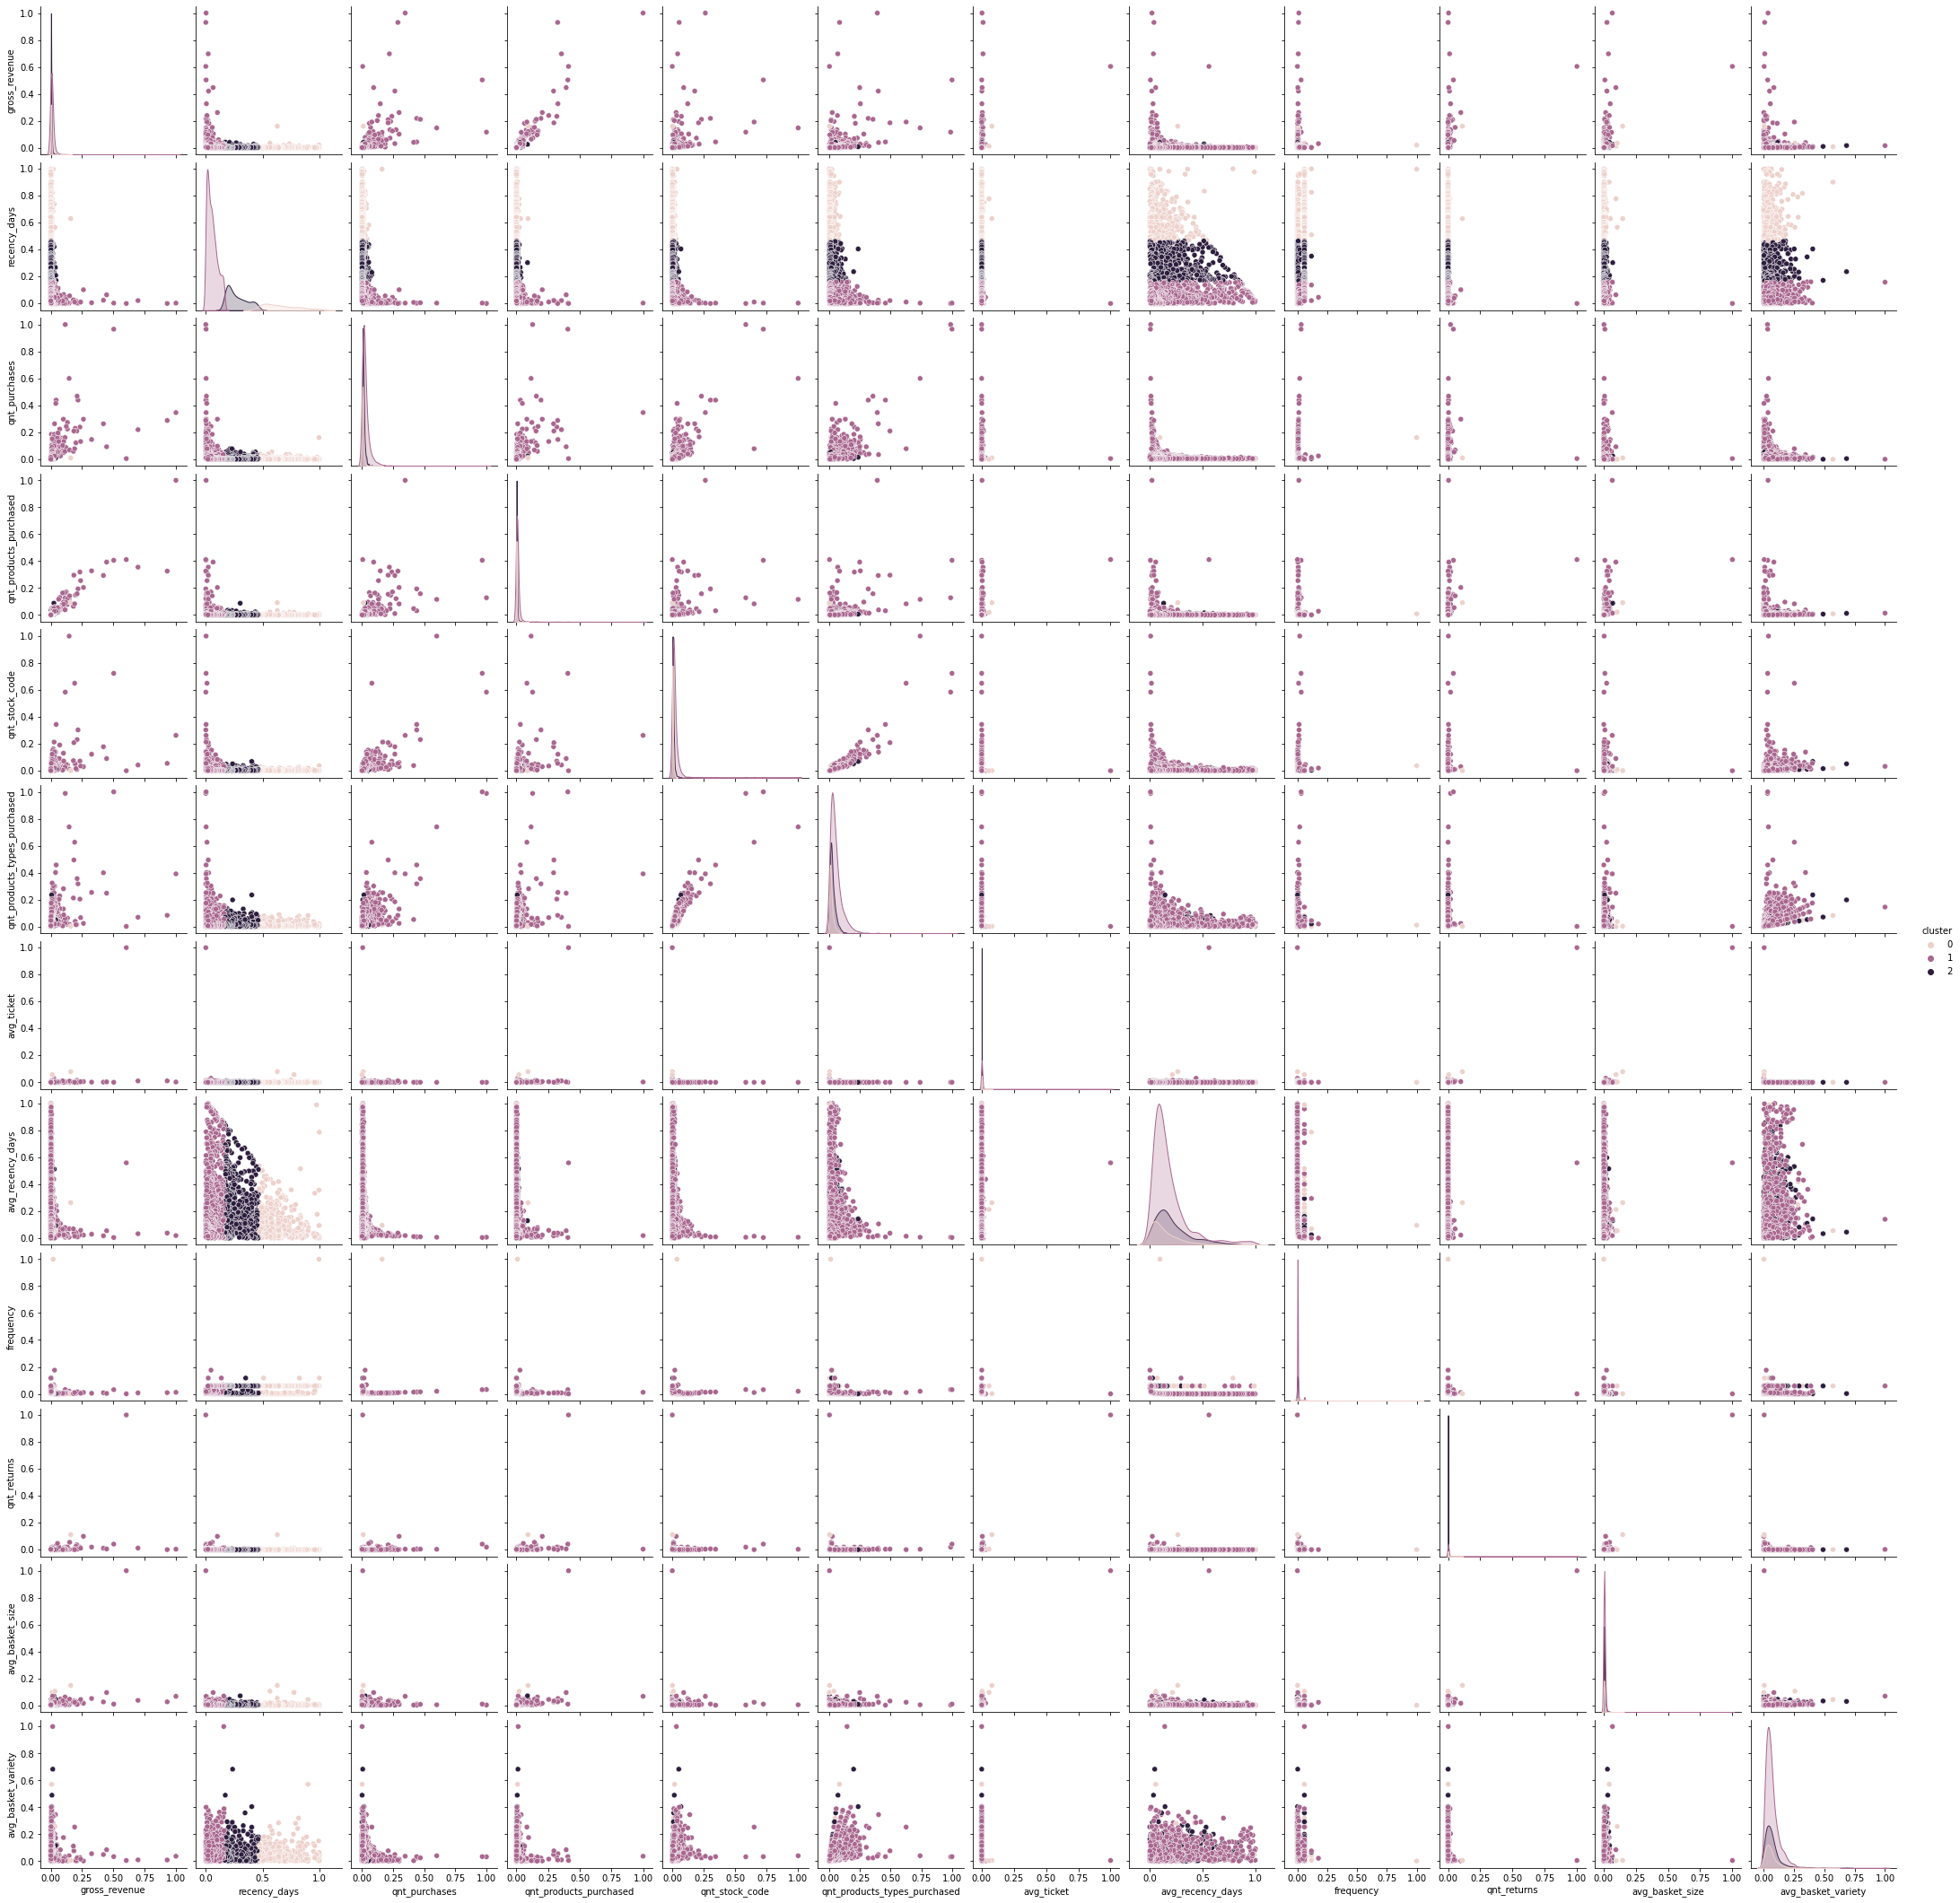

In [93]:
df_viz = df8.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

### UMAP

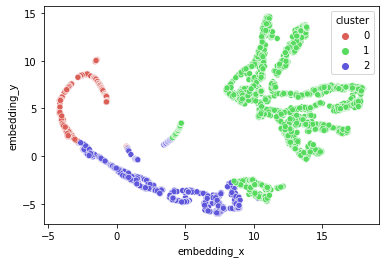

In [94]:
# instantiate UMAP
reducer = umap.UMAP(n_neighbors=20, random_state=42)

# transform data space into embedding
embedding = reducer.fit_transform(x)

# define x and y and save on df_viz dataset
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz);

## Cluster Profile

In [95]:
# Number of customers
df_cluster = df8[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross Revenue
df_gross_revenue = df8[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_recency_days = df8[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# Avg Qnt Product Types Purchased
df_frequency = df8[['qnt_products_types_purchased', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Avg Frequency
df_frequency = df8[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Avg Returns
df_frequency = df8[['qnt_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qnt_products_types_purchased,frequency,qnt_returns
0,0,333,11.215898,0.003061,0.660194,0.017550,0.023382,0.000586
1,1,1981,66.722802,0.012804,0.056574,0.053813,0.003410,0.001012
2,2,655,22.061300,0.004264,0.274514,0.027289,0.006696,0.000119


###  Cluster 01:  ( Candidatos Insider ) (OUT OF DATE)
- Número de customers: 6 (0.14% do customers )
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:
- Número de customers: 31 (0.71 do customers )
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:
- Número de customers: 4.335 (99% do customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

# Deploy